# 1st Place Solution Inference

Hi all,

I'm very exciting to writing this notebook and the summary of our solution here.

This is a small version of inference, using: 

* 5-fold stage1 models (128x128x128)
* 5-fold stage2 type1 models (224x224)
* 5-fold stage2 type2 models (224x224)

15 models in total.

After ALL models are trained, we now are able to do a submission.

I've already uploaded the models that using public notebooks but trained locally and made it public.

The submission time is around 130 min (mostly due to data loading) and is able to get such scores ↓

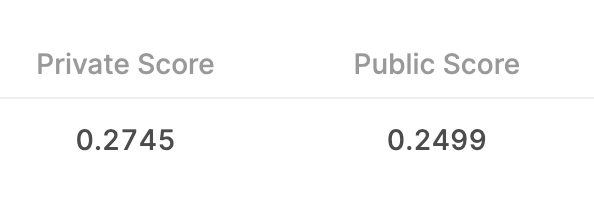

To get higher score, you only need to:

* use higher input resolution to train models.
* use bigger backbones.
* ensemble more models.

To see more details of my solution: https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/362607

* Train Stage1 Notebook: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-train-stage1
* Train Stage2 (Type1) Notebook: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-train-stage2-type1
* Train Stage2 (Type2) Notebook: https://www.kaggle.com/code/haqishen/rsna-2022-1st-place-solution-train-stage2-type2
* Inference Notebook: This notebook

Thanks!

In [ ]:
DEBUG = False

In [ ]:
import os
import sys
sys.path = [
    '../input/covn3d-same',
    '../input/timm20221011/pytorch-image-models-master',
    '../input/smp20210127/segmentation_models.pytorch-master/segmentation_models.pytorch-master',
    '../input/smp20210127/pretrained-models.pytorch-master/pretrained-models.pytorch-master',
    '../input/smp20210127/EfficientNet-PyTorch-master/EfficientNet-PyTorch-master',
] + sys.path

!pip -q install ../input/pylibjpeg140py3/pylibjpeg-1.4.0-py3-none-any.whl
!pip -q install ../input/pylibjpeg140py3/python_gdcm-3.0.17.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

!cp -r ../input/timm-20220211/pytorch-image-models-master/timm ./timm4smp

In [ ]:
import gc
import ast
import cv2
import time
import timm
import timm4smp
import pickle
import random
import pydicom
import argparse
import warnings
import threading
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from glob import glob
import albumentations
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from pylab import rcParams

%matplotlib inline
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

timm.__version__, timm4smp.__version__

In [ ]:
data_dir = '../input/rsna-2022-cervical-spine-fracture-detection/'
image_size_seg = (128, 128, 128)
msk_size = image_size_seg[0]
image_size_cls = 224
n_slice_per_c = 15
n_ch = 5

batch_size_seg = 1
num_workers = 2

In [ ]:
if DEBUG:
    df = pd.read_csv(os.path.join(data_dir, 'train.csv')).head(1500)
    df = pd.DataFrame({
        'StudyInstanceUID': df['StudyInstanceUID'].unique().tolist()
    })
    df['image_folder'] = df['StudyInstanceUID'].apply(lambda x: os.path.join(data_dir, 'train_images', x))
else:
    df = pd.read_csv(os.path.join(data_dir, 'test.csv'))
    if df.iloc[0].row_id == '1.2.826.0.1.3680043.10197_C1':
        # test_images and test.csv are inconsistent in the dev dataset, fixing labels for the dev run.
        df = pd.DataFrame({
            "row_id": ['1.2.826.0.1.3680043.22327_C1', '1.2.826.0.1.3680043.25399_C1', '1.2.826.0.1.3680043.5876_C1'],
            "StudyInstanceUID": ['1.2.826.0.1.3680043.22327', '1.2.826.0.1.3680043.25399', '1.2.826.0.1.3680043.5876'],
            "prediction_type": ["C1", "C1", "patient_overall"]}
        )
    df = pd.DataFrame({
        'StudyInstanceUID': df['StudyInstanceUID'].unique().tolist()
    })
    df['image_folder'] = df['StudyInstanceUID'].apply(lambda x: os.path.join(data_dir, 'test_images', x))

df.tail()

# Dataset

In [ ]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = cv2.resize(data, (image_size_seg[0], image_size_seg[1]), interpolation = cv2.INTER_AREA)
    return data


def load_dicom_line_par(path):

    t_paths = sorted(glob(os.path.join(path, "*")), key=lambda x: int(x.split('/')[-1].split(".")[0]))

    n_scans = len(t_paths)
#     print(n_scans)
    indices = np.quantile(list(range(n_scans)), np.linspace(0., 1., image_size_seg[2])).round().astype(int)
    t_paths = [t_paths[i] for i in indices]

    images = []
    for filename in t_paths:
        images.append(load_dicom(filename))
    images = np.stack(images, -1)
    
    images = images - np.min(images)
    images = images / (np.max(images) + 1e-4)
    images = (images * 255).astype(np.uint8)

    return images


class SegTestDataset(Dataset):

    def __init__(self, df):
        self.df = df.reset_index()

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]

        image = load_dicom_line_par(row.image_folder)
        if image.ndim < 4:
            image = np.expand_dims(image, 0)
        image = image.astype(np.float32).repeat(3, 0)  # to 3ch
        image = image / 255.
        return torch.tensor(image).float()


In [ ]:

dataset_seg = SegTestDataset(df)
loader_seg = torch.utils.data.DataLoader(dataset_seg, batch_size=batch_size_seg, shuffle=False, num_workers=num_workers)


In [ ]:
if DEBUG:
    rcParams['figure.figsize'] = 20,8
    for i in range(2):
        f, axarr = plt.subplots(1,4)
        for p in range(4):
            idx = i*4+p
            img = dataset_seg[idx]
            img = img[:, :, :, 60]
            axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())

In [ ]:
if DEBUG:
    rcParams['figure.figsize'] = 20,8
    for i in range(2):
        f, axarr = plt.subplots(1,4)
        for p in range(4):
            idx = i*4+p
            img = dataset_seg[idx]
            img = img[:, :, 60, :]
            axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())

In [ ]:
if DEBUG:
    rcParams['figure.figsize'] = 20,8
    for i in range(2):
        f, axarr = plt.subplots(1,4)
        for p in range(4):
            idx = i*4+p
            img = dataset_seg[idx]
            img = img[:, 60, :, :]
            axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())

# Model

In [ ]:
from timm4smp.models.layers.conv2d_same import Conv2dSame
from conv3d_same import Conv3dSame

def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output



class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm4smp.create_model(
            backbone,
            in_chans=3,
            features_only=True,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 3, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        if segtype == 'unet':
            self.decoder = smp.unet.decoder.UnetDecoder(
                encoder_channels=encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )
        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features
    
    
class TimmModel(nn.Module):
    def __init__(self, backbone, image_size, pretrained=False):
        super(TimmModel, self).__init__()
        self.image_size = image_size
        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=1,
            features_only=False,
            drop_rate=0,
            drop_path_rate=0,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone or 'nfnet' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()

        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=0, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 1),
        )
        self.lstm2 = nn.LSTM(hdim, 256, num_layers=2, dropout=0, bidirectional=True, batch_first=True)
        self.head2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 1),
        )


    def forward(self, x):  # (bs, nc*7, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * n_slice_per_c * 7, in_chans, self.image_size, self.image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, n_slice_per_c * 7, -1)
        feat1, _ = self.lstm(feat)
        feat1 = feat1.contiguous().view(bs * n_slice_per_c * 7, 512)
        feat2, _ = self.lstm2(feat)

        return self.head(feat1), self.head2(feat2[:, 0])
    
    
    
    
class Timm1BoneModel(nn.Module):
    def __init__(self, backbone, image_size, pretrained=False):
        super(Timm1BoneModel, self).__init__()
        self.image_size = image_size

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=1,
            features_only=False,
            drop_rate=0,
            drop_path_rate=0,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone or 'nfnet' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()

        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=0, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 1),
        )


    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * n_slice_per_c, in_chans, self.image_size, self.image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, n_slice_per_c, -1)
        feat, _ = self.lstm(feat)
        feat = feat.contiguous().view(bs * n_slice_per_c, -1)
        feat = self.head(feat)
        feat = feat.view(bs, n_slice_per_c).contiguous()

        return feat


# Load Models

In [ ]:
models_seg = []

#kernel_type = '/kaggle/input/seg-v2s-0911/timm3d_v2s_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_mixup1_lr1e3_20x50ep'
kernel_type='timm3d_res18d_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_bs4_lr3e4_20x50ep'
backbone = 'resnet18d'
model_dir_seg = '/kaggle/input/segv2s0911atika'
n_blocks = 4
for fold in range(5):
    model = TimmSegModel(backbone, pretrained=False)
    model = convert_3d(model)
    #model = model.to(device)
    load_model_file = os.path.join(model_dir_seg, f'{kernel_type}_fold{fold}_best.pth')
    sd = torch.load(load_model_file, map_location=torch.device('cpu'))
    if 'model_state_dict' in sd.keys():
        sd = sd['model_state_dict']
    sd = {k[7:] if k.startswith('module.') else k: sd[k] for k in sd.keys()}
    model.load_state_dict(sd, strict=True)
    model.eval()
    models_seg.append(model)

len(models_seg)

In [ ]:
kernel_type = '0920_1bonev2_effv2s_224_15_6ch_augv2_mixupp5_drl3_rov1p2_bs8_lr23e5_eta23e6_50ep'
del_dir_cls = '/kaggle/input/rsnastage2type1v2s224atika'
backbone = 'tf_efficientnetv2_s_in21ft1k'
in_chans = 6
models_cls1 = []

for fold in range(5):
    model = Timm1BoneModel(backbone, image_size=224, pretrained=False)
    load_model_file = os.path.join(del_dir_cls, f'{kernel_type}_fold{fold}_best.pth')
    sd = torch.load(load_model_file, map_location=torch.device('cpu'))
    if 'model_state_dict' in sd.keys():
        sd = sd['model_state_dict']
    sd = {k[7:] if k.startswith('module.') else k: sd[k] for k in sd.keys()}
    model.load_state_dict(sd, strict=True)
    #model = model.to(device)
    model.eval()
    models_cls1.append(model)

len(models_cls1)

In [ ]:
kernel_type = '0920_2d_lstmv22headv2_convnn_224_15_6ch_8flip_augv2_drl3_rov1p2_rov3p2_bs4_lr6e5_eta6e6_lw151_50ep'
model_dir_cls = '../input/rsnastage2type2convnn224atika'
backbone = 'convnext_nano'
in_chans = 6
models_cls2 = []

for fold in range(5):
    model = TimmModel(backbone, image_size=224, pretrained=False)
    #model = model.to(device)
    load_model_file = os.path.join(model_dir_cls, f'{kernel_type}_fold{fold}_best.pth')
    sd = torch.load(load_model_file, map_location=torch.device('cpu'))
    if 'model_state_dict' in sd.keys():
        sd = sd['model_state_dict']
    sd = {k[7:] if k.startswith('module.') else k: sd[k] for k in sd.keys()}
    model.load_state_dict(sd, strict=True)
    model.eval()
    models_cls2.append(model)

len(models_cls2)

In [ ]:
def load_bone(msk, cid, t_paths, cropped_images):
    n_scans = len(t_paths)
    bone = []
    try:
        msk_b = msk[cid] > 0.2
        msk_c = msk[cid] > 0.05

        x = np.where(msk_b.sum(1).sum(1) > 0)[0]
        y = np.where(msk_b.sum(0).sum(1) > 0)[0]
        z = np.where(msk_b.sum(0).sum(0) > 0)[0]

        if len(x) == 0 or len(y) == 0 or len(z) == 0:
            x = np.where(msk_c.sum(1).sum(1) > 0)[0]
            y = np.where(msk_c.sum(0).sum(1) > 0)[0]
            z = np.where(msk_c.sum(0).sum(0) > 0)[0]

        x1, x2 = max(0, x[0] - 1), min(msk.shape[1], x[-1] + 1)
        y1, y2 = max(0, y[0] - 1), min(msk.shape[2], y[-1] + 1)
        z1, z2 = max(0, z[0] - 1), min(msk.shape[3], z[-1] + 1)
        zz1, zz2 = int(z1 / msk_size * n_scans), int(z2 / msk_size * n_scans)

        inds = np.linspace(zz1 ,zz2-1 ,n_slice_per_c).astype(int)
        inds_ = np.linspace(z1 ,z2-1 ,n_slice_per_c).astype(int)
        for sid, (ind, ind_) in enumerate(zip(inds, inds_)):

            msk_this = msk[cid, :, :, ind_]

            images = []
            for i in range(-n_ch//2+1, n_ch//2+1):
                try:
                    dicom = pydicom.read_file(t_paths[ind+i])
                    images.append(dicom.pixel_array)
                except:
                    images.append(np.zeros((512, 512)))

            data = np.stack(images, -1)
            data = data - np.min(data)
            data = data / (np.max(data) + 1e-4)
            data = (data * 255).astype(np.uint8)
            msk_this = msk_this[x1:x2, y1:y2]
            xx1 = int(x1 / msk_size * data.shape[0])
            xx2 = int(x2 / msk_size * data.shape[0])
            yy1 = int(y1 / msk_size * data.shape[1])
            yy2 = int(y2 / msk_size * data.shape[1])
            data = data[xx1:xx2, yy1:yy2]
            data = np.stack([cv2.resize(data[:, :, i], (image_size_cls, image_size_cls), interpolation = cv2.INTER_LINEAR) for i in range(n_ch)], -1)
            msk_this = (msk_this * 255).astype(np.uint8)
            msk_this = cv2.resize(msk_this, (image_size_cls, image_size_cls), interpolation = cv2.INTER_LINEAR)

            data = np.concatenate([data, msk_this[:, :, np.newaxis]], -1)

            bone.append(torch.tensor(data))

    except:
        for sid in range(n_slice_per_c):
            bone.append(torch.ones((image_size_cls, image_size_cls, n_ch+1)).int())

    cropped_images[cid] = torch.stack(bone, 0)


def load_cropped_images(msk, image_folder, n_ch=n_ch):

    t_paths = sorted(glob(os.path.join(image_folder, "*")), key=lambda x: int(x.split('/')[-1].split(".")[0]))
    for cid in range(7):
        threads[cid] = threading.Thread(target=load_bone, args=(msk, cid, t_paths, cropped_images))
        threads[cid].start()
    for cid in range(7):
        threads[cid].join()

    return torch.cat(cropped_images, 0)


# Predict

In [ ]:
outputs1 = []
outputs2 = []

bar = tqdm(loader_seg)
with torch.no_grad():
    for batch_id, (images) in enumerate(bar):
        #images = images.cuda()
        device=torch.device('cpu')
        images.to(device)

        # SEG
        pred_masks = []
        for model in models_seg:
            pmask = model(images).sigmoid()
            pred_masks.append(pmask)
        pred_masks = torch.stack(pred_masks, 0).mean(0).cpu().numpy()

        # Build cls input
        cls_inp = []
        threads = [None] * 7
        cropped_images = [None] * 7

        for i in range(pred_masks.shape[0]):
            row = df.iloc[batch_id*batch_size_seg+i]
            cropped_images = load_cropped_images(pred_masks[i], row.image_folder)
            cls_inp.append(cropped_images.permute(0, 3, 1, 2).float() / 255.)
        cls_inp = torch.stack(cls_inp, 0).to(device)  # (1, 105, 6, 224, 224)

        pred_cls1, pred_cls2 = [], []
        # CLS 2
        for _, model in enumerate(models_cls2):
            logits, logits2 = model(cls_inp)
            pred_cls1.append(logits.sigmoid().view(-1, 7, n_slice_per_c))
            pred_cls2.append(logits2.sigmoid())

        # CLS 1
        cls_inp = cls_inp.view(7, 15, 6, image_size_cls, image_size_cls).contiguous()
        for _, model in enumerate(models_cls1):
            logits = model(cls_inp)
            pred_cls1.append(logits.sigmoid().view(-1, 7, n_slice_per_c))

        pred_cls1 = torch.stack(pred_cls1, 0).mean(0)
        pred_cls2 = torch.stack(pred_cls2, 0).mean(0)
        outputs1.append(pred_cls1.cpu())
        outputs2.append(pred_cls2.cpu())


# Output

In [ ]:
outputs1 = torch.cat(outputs1)
outputs2 = torch.cat(outputs2)

In [ ]:
PRED1 = (outputs1.mean(-1)).clamp(0.0001, 0.9999)
PRED2 = (outputs2.view(-1)).clamp(0.0001, 0.9999)

In [ ]:
row_ids = []
for _, row in df.iterrows():
    for i in range(7):
        row_ids.append(row.StudyInstanceUID + f'_C{i+1}')
    row_ids.append(row.StudyInstanceUID + '_patient_overall')

In [ ]:
df_sub = pd.DataFrame({
    'row_id': row_ids,
    'fractured': torch.cat([PRED1, PRED2.unsqueeze(1)], 1).view(-1),
})

In [ ]:
df_sub.to_csv('submission.csv', index=False)

In [ ]:
df_sub